# Set up functions

In [8]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import matplotlib.style
import matplotlib as mpl
import scipy 
import time

# set up regular expressions
# use https://regexper.com to visualise these if required
rx_dict = {
    'load_step': re.compile(r'Load step \d+ \( \d+ \) \[ (?P<load_step>\d+) \].*\n'),
    'load_factor': re.compile(r'F_lambda2.*lambda =.*(?P<load_factor> \d+\.\d+)\n'),
    # 'snes_nb_its': re.compile(r'(?P<snes_nb_its>\d+) SNES Function norm (?P<snes_error>\d+\.\d+e[-+]\d+) \['),
    'elastic_energy': re.compile(r'Propagation step.*Elastic energy (?P<elastic_energy>\d+\.\d+e[-+]\d+).*\n'),
    'crack_length': re.compile(r'Crack front length =  (?P<crack_length>\d+\.\d+e[-+]\d+).*\n'),
    'crack_area': re.compile(r'Crack surface area =  (?P<crack_area>\d+\.\d+e[-+]\d+).*\n'),
    'diverged': re.compile(r'\*\*\* Diverged \*\*\*')
}


def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """

    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None


def parse_file(filepath):
    """
    Parse text at given filepath

    Parameters
    ----------
    filepath : str
        Filepath for file_object to be parsed

    Returns
    -------
    data : dictionary

    """

    load_steps_list = []
    crack_area_list = []
    load_factor_list = []
    # snes_nb_its_int_list = []
    crack_length_list = []
    elastic_energy_list = []
    snes_error_list = []
    
    load_step_int = 0
    load_factor_float = 0.0
    # snes_nb_its_int = 0
    crack_length_float = 0.0
    elastic_energy = 0.0
    get_crack_area = False
    start_load_step = False
    diverged = False
    
    data = []  # create an empty list to collect the data
    # open the file and read through it line by line
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            # at each line check for a match with a regex
            key, match = _parse_line(line)
            
            if key == 'load_step':
                load_step = match.group('load_step')
                load_step_int = int(load_step)
                start_load_step = True
                
            if start_load_step:
                
                if key == 'load_factor':
                    load_factor = match.group('load_factor')
                    load_factor_float = float(load_factor)
               
                # if key == 'snes_nb_its':
                #     snes_nb_its = match.group('snes_nb_its')
                #     snes_nb_its_int = int(snes_nb_its)
                #     snes_error = match.group('snes_error')
                #     snes_error_float = float(snes_error)
                #     snes_error_list.append(snes_error_float)
                
            if key == 'crack_length':
                crack_length = match.group('crack_length')
                crack_length_float = float(crack_length)

            if key == 'elastic_energy':
                elastic_energy = match.group('elastic_energy')
                elastic_energy_float = float(elastic_energy)
                get_crack_area = True
            
            if key == 'diverged':
                diverged = True
                
            if start_load_step and get_crack_area:
                if key == 'crack_area':
                    if diverged:
                        diverged = False
                    else:
                        crack_area = match.group('crack_area')
                        crack_area = float(crack_area)
                        crack_area_list.append(crack_area)
                        crack_length_list.append(crack_length_float)
                        load_steps_list.append(load_step)
                        load_factor_list.append(load_factor_float)
                        # snes_nb_its_int_list.append(snes_nb_its_int)
                        elastic_energy_list.append(elastic_energy_float)
                        get_crack_area = False
                        start_load_step = False
                
            line = file_object.readline()
            
    data = {
        'load_step' : load_steps_list, 
        'load_factor' : load_factor_list, 
        'crack_area' : crack_area_list,
        'crack_length' : crack_length_list,
        'elastic_energy' : elastic_energy_list,
        # 'snes_nb_its' : snes_nb_its_int_list,
        'snes_error' : snes_error_list
    }

    return data

def remove_restarts(data):
    list_to_proces = [
        'load_factor', 
        'crack_area',
        'crack_length',
        'elastic_energy',
        # 'snes_nb_its',
        'load_step']
    
    for s in list_to_proces:
        list_to_replace = []
        for i,e in zip(data['load_step'], data[s]):
            if int(i) > len(list_to_replace)-1:
                list_to_replace.append(e)
            else:
                list_to_replace[int(i)] = e
        
        data[s] = list_to_replace
    
    return data

def remove_jumps(data, ave_window, tol):
    list_to_proces = [
        'load_factor', 
        'crack_area',
        'crack_length',
        'elastic_energy', 
        # 'snes_nb_its',    
        'load_step']
    
    ave_list = []
    for l,i in zip(data['load_factor'],range(len(data['load_factor'])-1)):
        ave = l
        count = 1
        for ii in range(i-ave_window,i-1):
            if ii >= 0:
                ave += data['load_factor'][ii]
                count += 1
                    
        for ii in range(i+1,i+ave_window):
            if ii < len(data['load_factor']):
                ave += data['load_factor'][ii]
                count += 1
                
        ave /= count
        ave_list.append(ave)

    list_to_keep = []
    for l,ave,i in zip(data['load_factor'],ave_list,range(len(ave_list)-1)):
        if abs((l-ave)/ave) < tol:
            list_to_keep.append(i)
            
    for s in list_to_proces:
        new_list = []
        for i in list_to_keep:
            new_list.append(data[s][i])
        data[s] = new_list
        
    return data

def post_proc(data):
    l_list = []
    for l in data['load_factor']:
        l_list.append(abs(l))
    data['load_factor'] = l_list
    
    u_list = []
    for e, l in zip(data['elastic_energy'], data['load_factor']):
        if l != 0:
            u = 2*(e / l)
        else: 
            u = 0
        u_list.append(u)
     
    # accumalte_its = [data['snes_nb_its'][0]]
    # for i in range(1,len(data['snes_nb_its'])):
    #     accumalte_its.append(data['snes_nb_its'][i] + accumalte_its[i-1])       

    data['displacement'] = u_list
    # data['accumulate_snes_nb_its'] = accumalte_its
    
    return data

def plotting(data_list,colors,labels):
    # plt.clf()
    # plt.figure(1)

    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.family'] = "Times"
    plt.rcParams['font.size'] = 16

    plt.title("Load factor vs crack area")
    plt.ylabel("Load factor")
    plt.xlabel("Crack area")
    for data,c,lab in zip(data_list,colors,labels):
        plt.plot(data['crack_area'], data['load_factor'], color=c, marker='o',label=lab)
    plt.legend()
    plt.ylim(0, 2)
    # plt.savefig('load_vs_area.png')

    plt.figure(2)
    plt.title("Elastic energy vs crack area")
    plt.ylabel("Elastic energy")
    plt.xlabel("Crack area")
    for data,c,lab in zip(data_list,colors,labels):
        plt.plot(data['crack_area'], data['elastic_energy'], color=c, marker='o',label=lab)
    plt.legend()
    # plt.savefig('energy_vs_area.png')

    plt.figure(3)
    plt.title("Load vs displacement")
    plt.ylabel("Load")
    plt.xlabel("Displacement")
    for data,c,lab in zip(data_list,colors,labels):
        plt.plot(data['displacement'], data['load_factor'], color=c, marker='o',label=lab)
        plt.plot([0,data['displacement'][0]], [0,data['load_factor'][0]], color=c, marker='o',label='_nolegend_')
    plt.legend()
    # plt.savefig('load_vs_disp.png')

    # plt.figure(4)
    # plt.title("Iteration number vs crack area")
    # plt.ylabel("Iteration number")
    # plt.xlabel("Crack area")
    # for data,c,lab in zip(data_list,colors,labels):
    #     plt.plot(data['crack_area'], data['accumulate_snes_nb_its'], color=c, marker='o',label=lab)
    # plt.legend()
    # plt.set_ylim(0,None)

    # fig, ax = plt.subplots(4,1)
    # fig.subplots_adjust(hspace=0.5)

    # ax[0].set_title("Load factor vs crack area")
    # ax[0].set_ylabel("Load factor")
    # ax[0].set_xlabel("Crack area")
    # for data,c in zip(data_list,colors):
    #     ax[0].plot(data['crack_area'], data['load_factor'], color=c, marker='o')
    # ax[0].set_ylim(0,None)
        
    # ax[1].set_title("Load factor vs crack length")
    # ax[1].set_ylabel("Load factor")
    # ax[1].set_xlabel("Crack length")
    # for data,c in zip(data_list,colors):
    #     ax[1].plot(data['crack_length'], data['load_factor'], color=c, marker='o')
    # ax[1].set_ylim(0,None)
        
    # ax[2].set_title("load vs displacement")
    # ax[2].set_ylabel("Load")
    # ax[2].set_xlabel("Displacement")
    # for data,c in zip(data_list,colors):
    #     ax[2].plot(data['displacement'], data['load_factor'], color=c)
    #     ax[2].plot([0,data['displacement'][0]], [0,data['load_factor'][0]], color=c, marker='o')
    # ax[2].set_ylim(0,None)
    # ax[2].set_xlim(0,None)
    
    # ax[3].set_title("Interation for step")
    # ax[3].set_ylabel("Iteration number")
    # ax[3].set_xlabel("Crack area")
    # for data,c in zip(data_list,colors):
    #     ax[3].plot(data['crack_area'], data['accumulate_snes_nb_its'], color=c, marker='o')
        
    #ax[4].set_title("Sness error")
    #ax[4].set_ylabel("Snes error")
    #ax[4].set_xlabel("Iteration number")
    #for data,c in zip(data_list,colors):
    #    ax[4].plot(data['snes_error'], color=c, marker='o')    
    #ax[4].set_ylim(0,2)
    
    #plt.show()
    #fig.savefig('fig_log.png')
    #plt.savefig('fig_log.png')
    #plt.close()
    

 

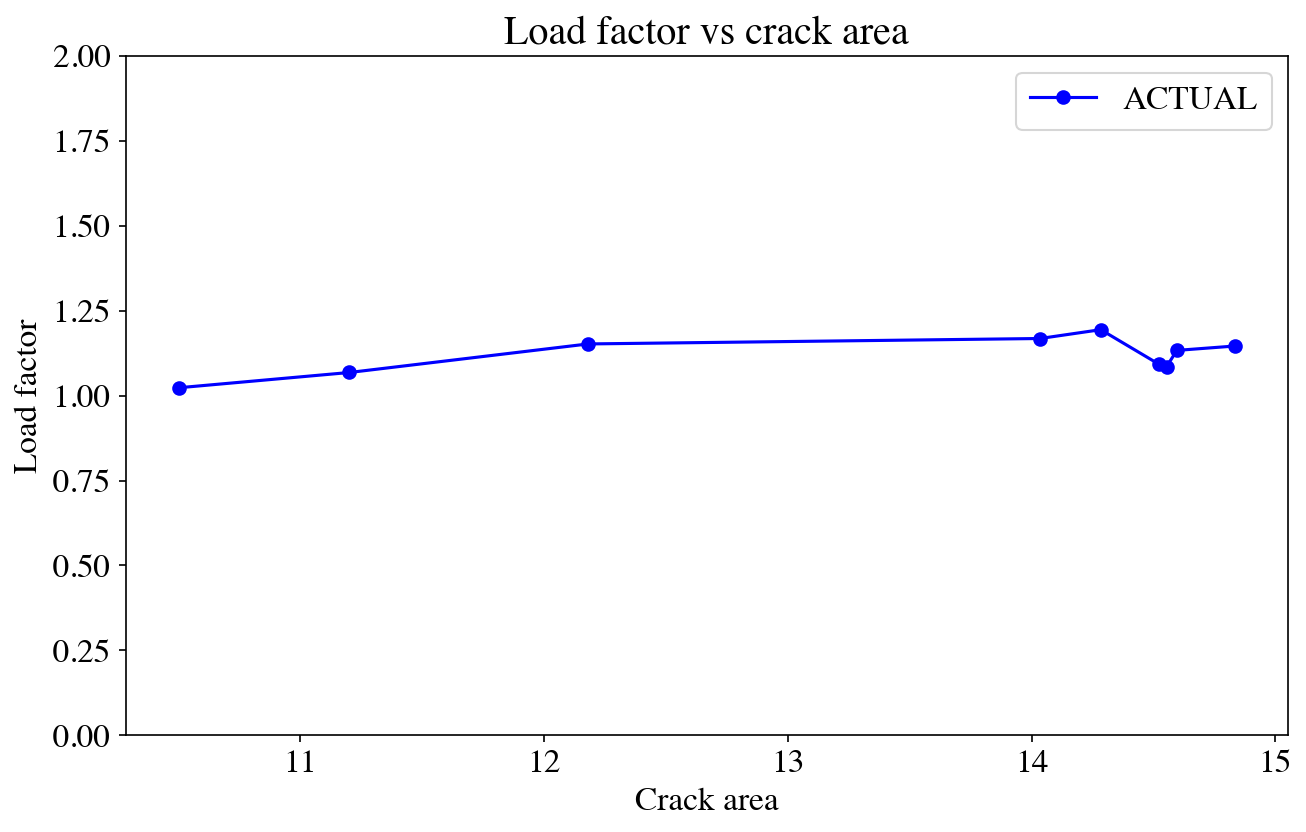

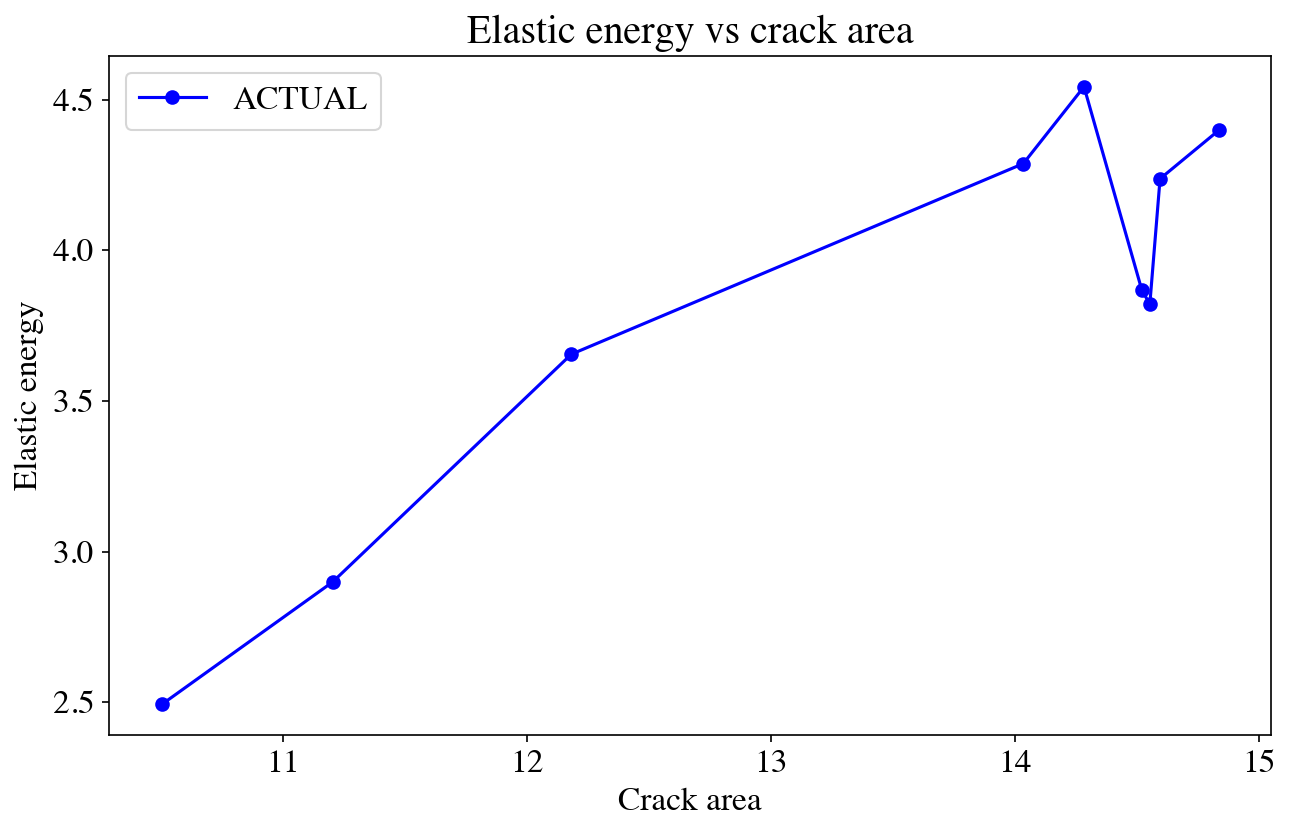

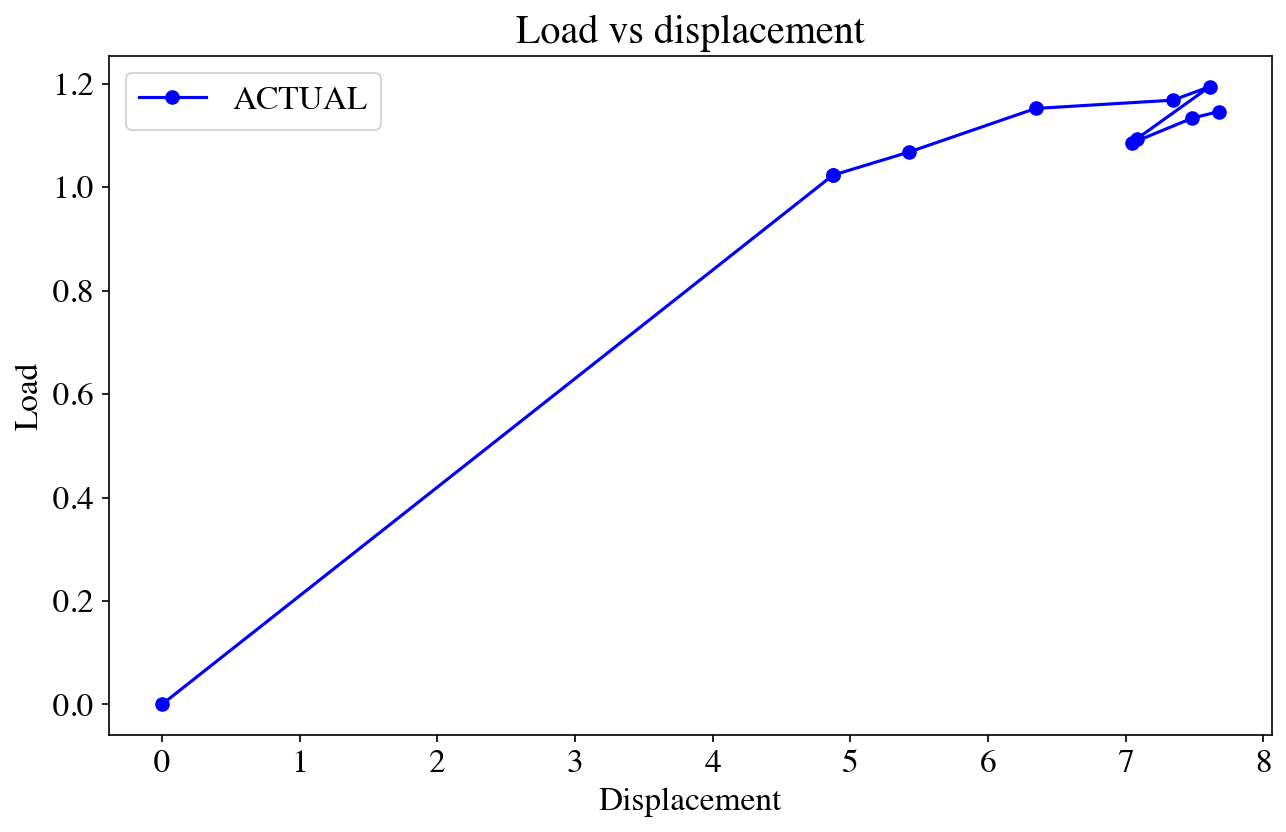

In [18]:
if __name__ == '__main__':
    
    # files = ["/Users/ashvarts/mofem_install/um_release/fracture_mechanics/examples/three_point_bending_contact/log", "//Users/ashvarts/Tests/fracture/3point_bending/log"]

    files =  ["/Users/ashvarts/storage/tests/fracture/contact_test/mortar_contact/actual_stress/gap_0/log"]

    colors = ['b', 'r', 'g', 'm', 'k']
    labels = ["ACTUAL"] # "matching contact", "mortar contact gap = 0"]

    data_list = []
    for file in files:
        data = parse_file(file)
        data = remove_restarts(data)
        data = remove_jumps(data, 10, 1)
        data = post_proc(data)
        data_list.append(data)
    
    plotting(data_list,colors,labels)   
    plt.show()

In [540]:
#save_data = data

In [596]:
if __name__ == '__main__':
    
    files = [
        '/Users/likask/MyBuild/spack_um_opt/build/fracture_mechanics/brick_with_half_keyway/log7',
        '/Users/likask/MyBuild/spack_um_opt/build/fracture_mechanics/brick_with_half_keyway/log10'
    ]
    colors = ['red', 'red', 'blue']
    
    data_list = [save_data]
    for file in files:
        data = parse_file(file)
        data = remove_restarts(data)
        data = remove_jumps(data, 10, 0.5)
        data = post_proc(data)
        data_list.append(data)

    plotting(data_list,colors)

<Figure size 1440x5760 with 0 Axes>